### <font color='red'> RUN INITIALIZATION CELLS FIRST! (Importing and functions)

In [15]:
# draw a bar that shows that the initialization is finished
from ipywidgets import FloatProgress
from IPython.display import display
initialization_bar = FloatProgress(min = 0, max = 1, description='Initializing:', bar_style='success')
initialization_bar.value = 0
display(initialization_bar)

In [29]:
gpu_fraction = 0.4
KTF.set_session(get_session(gpu_fraction))

### Parameters

In [29]:
filename = 'save.p' # Datafile with tracks, end with .p

# Additional features, options 'meanMSD' and 'xy'. Distance (between x0, y0 and x1, y1) is always used.
# 'meanMSD' is the mean of MSDs up until maxOrder, with shift.
# 'xy' are xy cordinates (x0, y0, x1, y1).
addFeat = ['meanMSD', 'xy']

# Maximum order of MSDs in 'meanMSD' (minimum order is 1)
maxOrder = 2

# Shift for calculating mean of MSDs in 'meanMSD'. 
# For odd orders, the mean of 2 * shift + 1 MSDs will be taken, for even orders, the mean of 2 * shift MSDs will be taken.
#(In this way, the means are always taken from MSDs symmetric around middle distance.)
shift = 3


windowSizeAr = [5, 10, 15, 20, 25] # Size of sliding window to get sets (number of distances)
numHiddenAr = [100, 200, 300, 400] # Number of hidden units


kSplit = 10


numTrain = 1000 # Number of training sets
numVal = 500 # Number of validation sets
numTest = 500 # Number of testing sets


numEp = 1000 # Maximum number of epochs
batchSize = 2**8 # Batchsize

minDel = 0
pat = 5

### Code

In [30]:
numSets = numTrain + numTest + numVal # Total amount of sets
vp = numVal / (numTrain + numVal) # Validationpercentage
tp = numTest / numSets # Testpercentage

earlystop = EarlyStopping(monitor = 'val_loss', min_delta = minDel, patience = pat, verbose = 1, mode = 'auto')

accTrain = np.empty((len(windowSizeAr), len(numHiddenAr), kSplit))
accTest = np.empty((len(windowSizeAr), len(numHiddenAr), kSplit))

accTestGrad = [] # For gradient accuracy over window

# Loading, getting all features
x, y, s = loadData(filename)
print('Data loaded')
d, trs = getDistTrS(x, y, s)
feat = getFeatVec(d, x, y, addFeat, maxOrder, shift)
print('Features extracted')

maxSets = getMaxSets(trs, windowSizeAr)

for k in range(kSplit):
    accTestGradK = []
    print('\nSplit ' + str(k + 1))
    for windowSize in windowSizeAr: 

        # Creating sets of size windowSize (sliding window)
        featSets, trsSets, numFeat = getFeatTrsSets(feat, trs, windowSize, addFeat, maxOrder)

        # Classes 0 / 1 / 2 need to be converted into 1 0 0 / 0 1 0 / 0 0 1
        nClasses = 3
        trs3class = keras.utils.to_categorical(trsSets, num_classes = nClasses).reshape(len(trsSets), windowSize, nClasses)

        # Split data into train and test set (with shuffeling)
        featShuf, trsShuf = shuffle2zip(featSets, trs3class)
        featMax, trsMax = featShuf[:maxSets], trsShuf[:maxSets]
        featMaxShuf, trsMaxShuf = shuffle2zip(featMax, trsMax)
        
        (featTrain, trsTrain), (featTest, trsTest) = splitTrainTest(featMaxShuf[:numSets], trsMaxShuf[:numSets],\
                                                                    testpercentage = tp)

        print('\nWindowsize = %s (in total %s sets, took %s sets)' %(windowSize, len(featSets), maxSets))

        for numHidden in numHiddenAr:
            print('h = %s' %(numHidden))

            # Creating model
            model = Sequential()
            model.add(Bidirectional(LSTM(numHidden, return_sequences = True), input_shape = (windowSize, numFeat), merge_mode = 'concat'))
            model.add(TimeDistributed(Dense((nClasses), activation = 'softmax'))) # Softmax to get 'probability distribution' 
            model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
            #print(model.summary())

            # Training
            history = model.fit(featTrain, trsTrain, callbacks = [earlystop], epochs = numEp,\
                        batch_size = batchSize, verbose = 0, validation_split = vp, shuffle = True)

            # Predicting on test set and convert 1 0 0 / 0 1 0 / 0 0 1 back into 0 / 1 / 2
            predicted = model.predict(featTest)
            trsPred = predicted.argmax(axis = 2) # Predicted transition states
            trsReal = trsTest.argmax(axis = 2) # Real transition states

            # Get accuracy on train and test data
            accTrain[windowSizeAr.index(windowSize), numHiddenAr.index(numHidden), k] =\
            np.array(history.history['acc'][-5:]).mean()

            total = 0
            accurate = 0
            for pred, real in zip(trsPred, trsReal):
                for p, r in zip(pred, real):
                    total += 1
                    if p == r:
                        accurate += 1
            accTest[windowSizeAr.index(windowSize), numHiddenAr.index(numHidden), k] = accurate / total
            
            gradList = []
            for pred, real in zip(trsPred, trsReal):
                grad = []
                for p, r in zip(pred, real):
                    if p == r:
                        grad.append(1)
                    else:
                        grad.append(0)
                gradList.append(grad)
            accTestGradK.append(gradList)
    accTestGrad.append(accTestGradK)

Data loaded
Features extracted

Split 1

Windowsize = 5 (in total 10348 sets, took 8541 sets)
h = 100
Epoch 00068: early stopping
h = 200
Epoch 00036: early stopping
h = 300
Epoch 00037: early stopping
h = 400
Epoch 00029: early stopping

Windowsize = 10 (in total 9862 sets, took 8541 sets)
h = 100
Epoch 00094: early stopping
h = 200
Epoch 00055: early stopping
h = 300
Epoch 00042: early stopping
h = 400
Epoch 00041: early stopping

Windowsize = 15 (in total 9403 sets, took 8541 sets)
h = 100
Epoch 00162: early stopping
h = 200
Epoch 00064: early stopping
h = 300
Epoch 00050: early stopping
h = 400
Epoch 00044: early stopping

Windowsize = 20 (in total 8964 sets, took 8541 sets)
h = 100
Epoch 00151: early stopping
h = 200
Epoch 00101: early stopping
h = 300
Epoch 00063: early stopping
h = 400
Epoch 00077: early stopping

Windowsize = 25 (in total 8541 sets, took 8541 sets)
h = 100
Epoch 00148: early stopping
h = 200
Epoch 00130: early stopping
h = 300
Epoch 00076: early stopping
h = 40

h = 400
Epoch 00039: early stopping

Windowsize = 10 (in total 9862 sets, took 8541 sets)
h = 100
Epoch 00072: early stopping
h = 200
Epoch 00065: early stopping
h = 300
Epoch 00054: early stopping
h = 400
Epoch 00054: early stopping

Windowsize = 15 (in total 9403 sets, took 8541 sets)
h = 100
Epoch 00110: early stopping
h = 200
Epoch 00075: early stopping
h = 300
Epoch 00078: early stopping
h = 400
Epoch 00072: early stopping

Windowsize = 20 (in total 8964 sets, took 8541 sets)
h = 100
Epoch 00155: early stopping
h = 200
Epoch 00109: early stopping
h = 300
Epoch 00087: early stopping
h = 400
Epoch 00080: early stopping

Windowsize = 25 (in total 8541 sets, took 8541 sets)
h = 100
Epoch 00173: early stopping
h = 200
Epoch 00107: early stopping
h = 300
Epoch 00087: early stopping
h = 400
Epoch 00068: early stopping

Split 10

Windowsize = 5 (in total 10348 sets, took 8541 sets)
h = 100
Epoch 00058: early stopping
h = 200
Epoch 00042: early stopping
h = 300
Epoch 00035: early stopping


In [31]:
accTrainMean = accTrain.mean(axis = 2)
accTestMean = accTest.mean(axis = 2)

In [32]:
#print('Training accuracy:\n%s\n' %(accTrain))
print('Mean training accuracy:\n%s\n' %(accTrainMean))
#print('Testing accuracy:\n%s\n' %(accTest))
print('Mean testing accuracy:\n%s\n' %(accTestMean))

Mean training accuracy:
[[ 0.85954     0.867492    0.874512    0.879796  ]
 [ 0.89529607  0.90337408  0.91288208  0.92052808]
 [ 0.92206267  0.94094268  0.93922802  0.94574801]
 [ 0.93908715  0.95535015  0.96024416  0.96278415]
 [ 0.95414496  0.96737455  0.97362096  0.98080335]]

Mean testing accuracy:
[[ 0.80056     0.79832     0.80028     0.79668   ]
 [ 0.829       0.83182     0.83204     0.8343    ]
 [ 0.85994667  0.8706      0.86898667  0.87076   ]
 [ 0.88329     0.89132     0.89391     0.89635   ]
 [ 0.905128    0.913864    0.91864     0.923688  ]]



In [33]:
saveLabel = 'Bidirectional_Feat' + str(addFeat).replace("'", "") + '_MaxOrder' + str(maxOrder) + '_Shift' + str(shift) + '_WS' + str(windowSize) + '_H' + str(numHidden) +\
'_' + str(kSplit) + 'splits_Train' + str(numTrain) + '_Val' + str(numVal) + '_Test' + str(numTest) + '_Batch' + str(batchSize)

print(saveLabel)
model.save(os.getcwd() + '/Models/Model_' + saveLabel)

Bidirectional_Feat[meanMSD, xy]_MaxOrder2_Shift3_WS25_H400_10splits_Train1000_Val500_Test500_Batch256


In [34]:
saveLabel = 'Bidirectional_Feat' + str(addFeat).replace("'", "") + '_MaxOrder' + str(maxOrder) + '_Shift' + str(shift) + '_WS' + str(windowSize) + '_H' + str(numHidden) +\
'_' + str(kSplit) + 'splits_Train' + str(numTrain) + '_Val' + str(numVal) + '_Test' + str(numTest) + '_Batch' + str(batchSize)

print(saveLabel)
model.save_weights(os.getcwd() + '/Models/Weights/Model_Weights_' + saveLabel)

Bidirectional_Feat[meanMSD, xy]_MaxOrder2_Shift3_WS25_H400_10splits_Train1000_Val500_Test500_Batch256


### Plotting

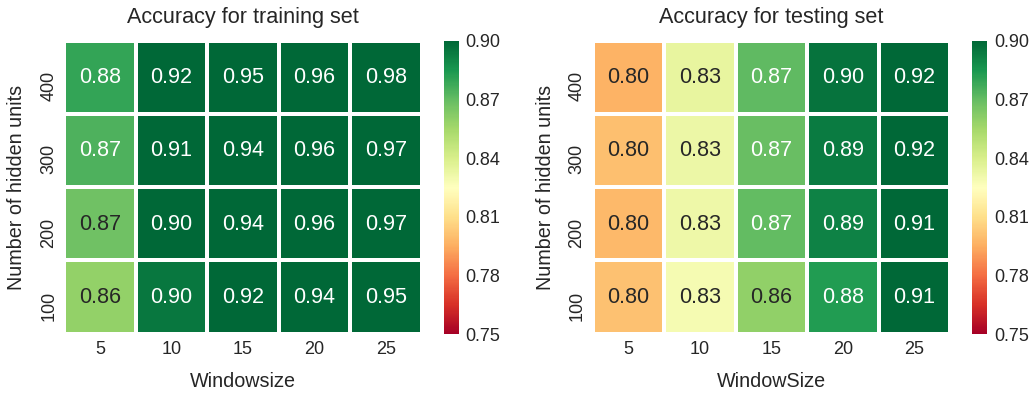

In [35]:
# Plot heatmap of mean accuracies

import seaborn as sns
from matplotlib import cm
sns.set(font_scale = 1.8)
plt.rcParams['figure.figsize'] = (15, 6)
plt.subplot(121)
ax = sns.heatmap(np.flipud(accTrainMean.T), annot = True, linewidths = 3, fmt = '.2f',\
                 xticklabels = windowSizeAr, yticklabels = np.flipud(numHiddenAr), cmap = cm.RdYlGn, vmin = 0.75, vmax = 0.9)
plt.xlabel('Windowsize', labelpad = 14)
plt.ylabel('Number of hidden units', labelpad = 14)
plt.title('Accuracy for training set', y = 1.04)

plt.subplot(122)
ax = sns.heatmap(np.flipud(accTestMean.T), annot = True, linewidths = 3, fmt = '.2f',\
                 xticklabels = windowSizeAr, yticklabels = np.flipud(numHiddenAr), cmap = cm.RdYlGn, vmin = 0.75, vmax = 0.9)
plt.xlabel('WindowSize', labelpad = 14)
plt.ylabel('Number of hidden units', labelpad = 14)
plt.title('Accuracy for testing set', y = 1.04)

plt.tight_layout()
#plt.savefig(os.getcwd() + something + '.pdf')

plt.show()

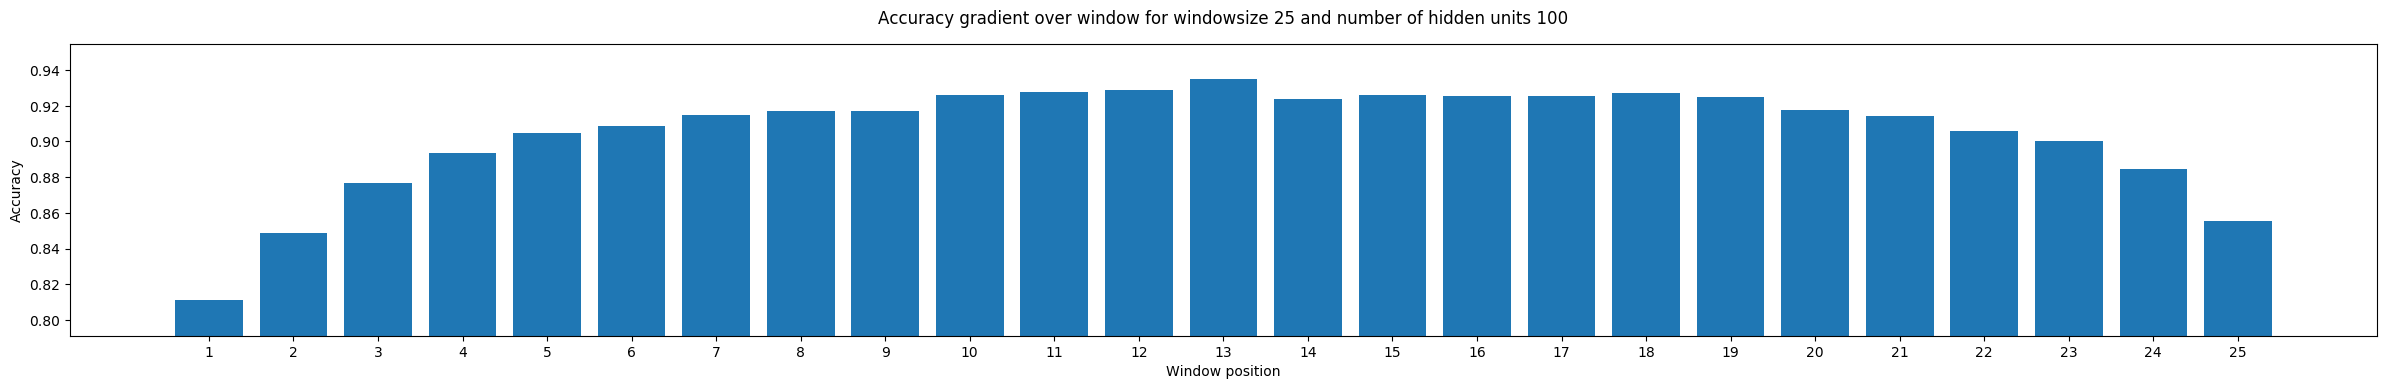

In [38]:
# Plotting a bar graph of the accuracy gradient over window for specified windowsize and number of hidden units

ws = 25 # windowsize
h = 100 # number of hidden units

if ws not in windowSizeAr or h not in numHiddenAr:
    print('No experiment for this ws-h combination.')
    
else:
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (24, 4)

    totList = []    

    for i in range(len(accTestGrad[0])):
        L = []
        for j in range(len(accTestGrad)):
            L.append(np.array(accTestGrad[j][i]).mean(axis = 0))
        totList.append(np.array(L).mean(axis = 0))

    ind =  windowSizeAr.index(ws) * len(numHiddenAr) + numHiddenAr.index(h)

    plt.bar(np.arange(ws) + 1, totList[ind])
    plt.gca().set_xticks(np.arange(ws) + 1)

    plt.xlabel('Window position')
    plt.ylabel('Accuracy')
    plt.title('Accuracy gradient over window for windowsize %s and number of hidden units %s' %(ws, h), y = 1.04)
    plt.gca().set_ylim([min(totList[ind] - 0.02), max(totList[ind] + 0.02)])
    plt.tight_layout()
    plt.show()

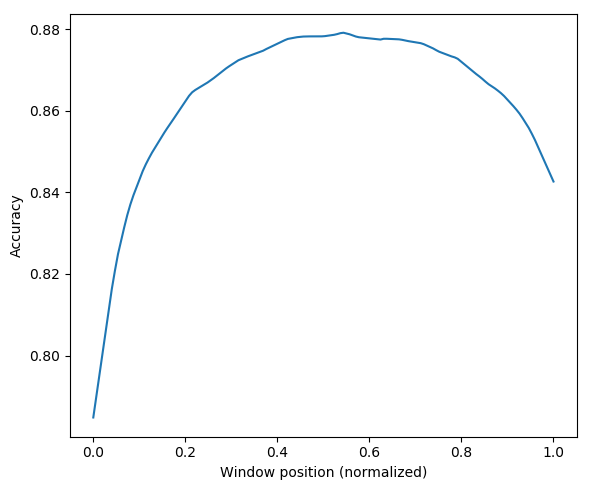

In [36]:
# Plot overall accuracy gradient for normalized windowsize between 0 and 1
plt.style.use('default')
plt.rcParams['figure.figsize'] = (6, 5)
numSamp = 150
bigList = []

for split in accTestGrad:
    for windowList in split:
        for L in windowList:
            M = np.interp(np.linspace(0, len(L) - 1, num = numSamp), range(len(L)), L)
            bigList.append(M)
        
superList = np.array(bigList).reshape(len(windowSizeAr) * len(numHiddenAr) * numTest * kSplit, numSamp)
superMean = superList.mean(axis = 0)

plt.plot(np.linspace(0, 1, numSamp), superMean)
plt.xlabel('Window position (normalized)')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

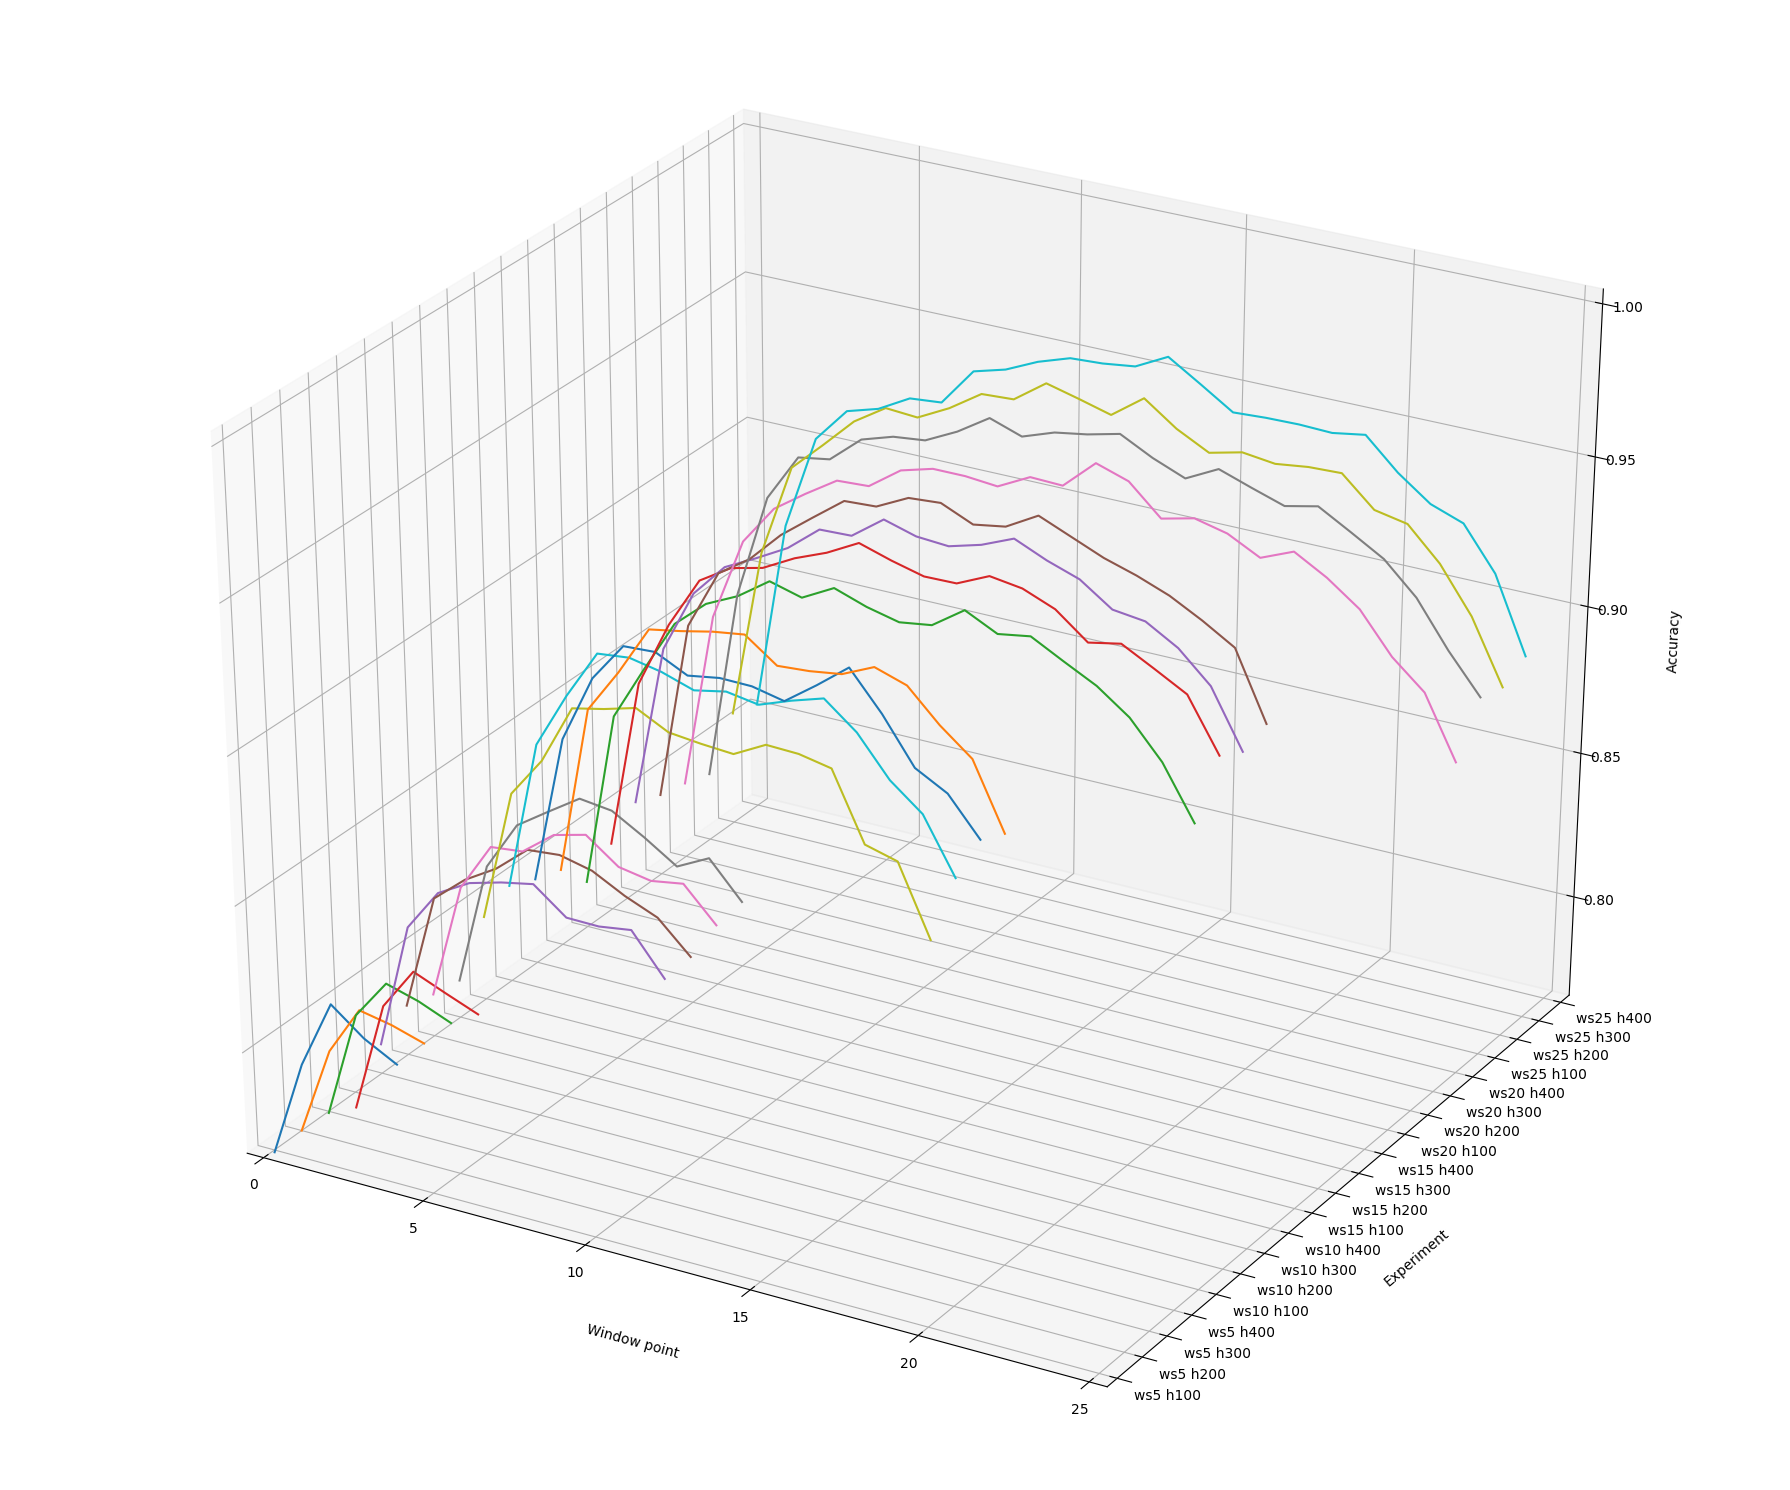

In [37]:
# Plot accuracy gradient per h&windowsize combo

plt.style.use('default')
plt.rcParams['figure.figsize'] = (18, 15)

totList = []    

for i in range(len(accTestGrad[0])):
    L = []
    for j in range(len(accTestGrad)):
        L.append(np.array(accTestGrad[j][i]).mean(axis = 0))
    totList.append(np.array(L).mean(axis = 0))

names = []
for ws in windowSizeAr:
    for h in numHiddenAr:
        names.append('ws%s h%s' %(ws,h))


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.gca(projection = '3d')

for i in range(len(totList)):
    xs = np.arange(len(totList[i]))
    ys = totList[i]
    ax.plot(xs, ys, zs = i, zdir = 'y')

ax.set_xlabel('Window point', labelpad = 20)
ax.set_xlim3d(0, max(windowSizeAr))
ax.set_ylabel('Experiment', labelpad = 28)
ax.set_ylim3d(0, (len(windowSizeAr) * len(numHiddenAr)) - 1)
ax.set_zlabel('Accuracy', labelpad = 20)
ax.set_zlim3d(0.77, 1)

plt.gca().set_xticks(np.arange(0, windowSizeAr[-1] + 1, 5)) 
plt.gca().set_zticks([0.80, 0.85, 0.90, 0.95, 1.00])
plt.gca().set_yticks(np.arange(len(windowSizeAr) * len(numHiddenAr))) 
plt.gca().set_yticklabels(names, va = 'center', ha = 'left')

plt.tight_layout()
plt.show()

### Initialization cells

#### Importing

In [16]:
# Importing and settings
import matplotlib.pyplot as plt
from matplotlib import cm
import math
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
import numpy as np

# Import stuff for training
import keras
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers.core import Dense  #,Dropout ?
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import GRU
from keras.layers.recurrent import SimpleRNN as sRNN

#from time import time
#from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping

#import shutil # for deleting log folder
import os

import pickle

#### Functions

In [17]:
# import to limit the GPU memory
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

def get_session(gpu_fraction):
    '''Assume that you have 6GB of GPU memory and want to allocate ~2GB'''

    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = gpu_fraction)

    if num_threads:
        return tf.Session(config = tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads = num_threads))
    else:
        return tf.Session(config = tf.ConfigProto(gpu_options = gpu_options))


In [18]:
# Load data

def loadData(filename):
    xystate = pickle.load(open(os.getcwd() + '/' + filename, 'rb'))
    x = np.array(xystate['Xcum'])
    y = np.array(xystate['Ycum'])
    s = np.array(xystate['StateList'])
    
    return x, y, s

In [19]:
def getDistTrS(x, y, s):    
    
    distances = []
    trStates = []

    for trackX, trackY, trackS in zip(x, y, s):
        dist = []
        trst = []        
        
        for j in range(len(trackX) - 1):            
            dist.append(np.sqrt((trackX[j + 1] - trackX[j]) ** 2 + (trackY[j + 1] - trackY[j]) ** 2))

            if trackS[j + 1] != trackS[j]:
                trst.append(1) # state 1 for switching from state 0 to 1 or 1 to 0
            elif trackS[j] == 0:
                trst.append(0) # state 0 for staying in state 0
            elif trackS[j] == 1:
                trst.append(2) # state 2 for staying in state 1
        
        distances.append(dist)
        trStates.append(trst)
    
    return distances, trStates

In [20]:
def getMeanMSDs(x, y, maxOrder, shift):

    D= []
    for trackX, trackY in zip(x, y):
        dTrack = []
        for order in range(1, maxOrder + 1):
            dOrder = []
            for j in range(len(trackX) - order):
                dOrder.append(np.sqrt((trackX[j + order] - trackX[j]) ** 2 + (trackY[j + order] - trackY[j]) ** 2))
            dTrack.append(dOrder)
        D.append(dTrack)

    dVec = []
    for track in D:
        vector = []
        for order in range(1, maxOrder + 1):
            v = []
            dO = track[order - 1]

            for i in range(len(track[0])):
                if order % 2 == 0:
                    iStart = (i - shift - ((order - 1) // 2))
                    iEnd = iStart + (2 * shift) - 1
                else:
                    iStart = (i - shift - (order // 2))
                    iEnd = iStart + (2 * shift)

                if iStart < 0:
                    iStart = 0

                if iEnd > (len(track[0]) - 1):
                    iEnd = len(track[0]) - 1

                meanPoint = np.mean(dO[iStart:(iEnd + 1)])
                v.append(meanPoint)
            vector.append(v)
        dVec.append(vector)

    return dVec

In [21]:
def getCoord(x, y):
    
    coordXY = []
    
    for trackX, trackY, trackS in zip(x, y, s):
        coxy = []
        
        for j in range(len(trackX) - 1):
            coxy.append([trackX[j], trackY[j], trackX[j + 1], trackY[j + 1]])
        coordXY.append(coxy)
        
    return coordXY

In [22]:
def getFeatVec(d, x, y, addFeat, maxOrder, shift):
    
    if 'meanMSD' in addFeat:
        dMeanVec = getMeanMSDs(x, y, maxOrder, shift)
        
    if 'xy' in addFeat:
        xy = getCoord(x, y)

    featVec = []
    for i in range(len(d)):
        featTrack = []
        for j in range(len(d[i])):
            featPoint = []
            featPoint.append(d[i][j])

            if 'meanMSD' in addFeat:             
                for order in range(maxOrder):
                    featPoint.append(dMeanVec[i][order][j])

            if 'xy' in addFeat:            
                featPoint.append(xy[i][j][0])
                featPoint.append(xy[i][j][1])
                featPoint.append(xy[i][j][2])
                featPoint.append(xy[i][j][3])

            featTrack.append(featPoint)
        featVec.append(featTrack)
    
    return featVec

In [23]:
def getFeatTrsSets(feat, trs, windowSize, addFeat, maxOrder):

    featSets = []
    trsSets = []

    numFeat = 1 + ('meanMSD' in addFeat) * maxOrder + ('xy' in addFeat) * 4

    for featVec, state in zip(feat, trs):
        for j in range(len(featVec) - windowSize + 1):
            featSets.append(featVec[j:j + windowSize])
            trsSets.append(state[j:j + windowSize])

        featSetsReshape = np.array(featSets).reshape((len(featSets), windowSize, numFeat))
        trsSetsReshape = np.array(trsSets).reshape((len(trsSets), windowSize, 1))
        
    return featSetsReshape, trsSetsReshape, numFeat

In [24]:
# function that gets number of sets for maximum windowsize in windowSizeAr

def getMaxSets(trs, windowSizeAr):
    
    windowMax = max(windowSizeAr)
    maxNum = 0
    
    for state in trs:
        for j in range(len(state)- windowMax + 1):
            maxNum += 1
            
    return maxNum

In [25]:
# Function that zips 2 arrays of same length and shuffles them

def shuffle2zip(A, B):
    Z = list(zip(A, B))
    np.random.shuffle(Z)
    Ashuf, Bshuf = zip(*Z)
    
    Ashuf = np.array(Ashuf)
    Bshuf = np.array(Bshuf)
    
    return Ashuf, Bshuf

In [26]:
# Function to split in training and test data

def splitTrainTest(featSets, trsSets, testpercentage = 0.1):
    numtrain = round((1 - testpercentage) * len(featSets))
    featTrain, trsTrain = featSets[:numtrain], trsSets[:numtrain]
    featTest, trsTest = featSets[numtrain:], trsSets[numtrain:]
    return (featTrain, trsTrain), (featTest, trsTest)

In [27]:
def get01states(Vec, windowSize):

    states01 = np.empty((len(Vec), windowSize + 1))

    for i in range(len(Vec)):
        v = Vec[i]       

        for j in range(windowSize):
            goBack = 0
            while v[j] == 1:
                j += 1
                goBack += 1

                if j > (windowSize - 1):
                    for k in range(goBack - 1, -1, -1):
                        states01[i, j - k] = abs(states01[i, j - k - 1] - 1)
                    break         

            else:
                if v[j] == 0:
                    if j > 1 and v[j - 1] == 1 and v[j - 2] == 0:
                        states01[i, j - 1:j + 1] = 10
                    else:
                        states01[i, j] = 0 + (j != 0 and states01[i, j] == 1) * 10         
                    states01[i, j + 1] = 0

                    for k in range(1, goBack + 1):
                        states01[i, j - k] = abs(states01[i, j - k + 1] - 1)

                elif v[j] == 2:  
                    if j > 1 and v[j - 1] == 1 and v[j - 2] == 2:
                        states01[i, j - 1:j + 1] = 10
                    else:
                        states01[i, j] = 1 + (j != 0 and states01[i, j] == 0) * 9     
                    states01[i, j + 1] = 1

                    for k in range(1, goBack + 1):
                        states01[i, j - k] = abs(states01[i, j - k + 1] - 1)

    return states01

In [28]:
# execution of initialization cells is done
initialization_bar.value += 1